# Анализ внешних данных с частотой в 1 день

## Оглавление

### Оглавление

1. **Импорт необходимых библиотек**
   - Подключение библиотек для анализа данных, работы с датами и API MOEX.

2. **Вспомогательные функции**

3. **Получение данных**

4. **Объединение данных**
   - Слияние данных по фьючерсам, ключевой ставке и валютным курсам в единый DataFrame.

5. **EDA**
   - Проверка пропущенных значений и их обработка.
   - Базовая статистика.
   - Визуализация временных рядов.
   - Тестирование временных рядов на стационарность.
   - Построение корреляционной матрицы курсов валют.

6. **Обработка временных рядов**
   - Преобразование данных для получения стационарных временных рядов.
   - ADF тест для всех временных рядов.
   - Построение автокорреляционных графиков (ACF и PACF).

7. **Скользящие окна**
   - Расчет скользящего изменения валютных курсов и цен на фьючерсы с использованием формулы сложного процента.
   - Визуализация скользящих изменений для различных временных окон (30 и 365 дней).

## 1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta, date, datetime
import apimoex
import requests
from bs4 import BeautifulSoup
import dateparser
import re
from lxml import etree
import time
from statsmodels.tsa.stattools import adfuller, acf, pacf

CURRENT_DATE = date.today()

## 2. Вспомогательные функции

- `BR_code` - преобразует дату в название фьючерса на нефть марки `Brent` (с тем же месяцем и годом исполнения)

In [2]:
def BR_code(on_date):
    current_year = CURRENT_DATE.year
    
    month_codes = 'FGHJKMNQUVXZ'
    month = on_date.month
    year = on_date.year
    year_code = str(year)[-1]
    month_code = month_codes[month-1]
    if year <= current_year - 6:
        return f"BR{month_code}{year_code}_{year}"
    else:
        return f"BR{month_code}{year_code}"

- `BR_decode` - возвращает дату (месяц и год) исполнения фьючерса из его названия

In [3]:
def BR_decode(code):
    month_codes = 'FGHJKMNQUVXZ'
    month_code = code[2]
    year_code = code[3]
    month = month_codes.index(month_code) + 1
    
    if "_" in code:
        year = int(code.split('_')[1])
    else:
        current_year = date.today().year
        current_decade = current_year // 10 * 10
        last_digit_of_current_year = current_year % 10
        year_last_digit = int(year_code)
        
        if year_last_digit > last_digit_of_current_year:
            year = current_decade - 10 + year_last_digit
        else:
            year = current_decade + year_last_digit
    return date(year, month, 1)

- `generate_BR_list` - создает список названий всех фьючерсов на нефть марки `Brent`, даты исполнения которых выпадают на указанный диапазон лет

In [4]:
def generate_BR_list(start_year, end_year):
    tickers = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            ticker_date = date(year, month, 1)
            ticker = BR_code(ticker_date)
            tickers.append(ticker)
    return tickers

- `get_BR_futures` - Возвращает данные по всем фьючерсам марки Brent, чьи дни исполнения попадают в диапазон указанных лет

In [5]:
def get_BR_futures(start_year: int = 2008, end_year: int = CURRENT_DATE.year + 1):
    tickers = generate_BR_list(start_year, end_year)
    df_futures = pd.DataFrame()
    with requests.Session() as session:
        for ticker in tickers:
            future = apimoex.get_board_history(
                session,
                board='RFUD',
                security=ticker,
                market='forts',
                engine='futures'
            )
            temp_df = pd.DataFrame(future)
            if df_futures.empty and not temp_df.empty:
                temp_df['ID'] = ticker
                df_futures = temp_df
                continue
            if not temp_df.empty:
                temp_df['ID'] = ticker
                df_futures = pd.concat([df_futures, temp_df], ignore_index=True)
            time.sleep(0.5)
    df_futures['Exp_date'] = pd.to_datetime(df_futures['ID'].apply(BR_decode))
    df_futures['TRADEDATE'] = pd.to_datetime(df_futures['TRADEDATE'])
    df_futures['delta_days'] = (df_futures['Exp_date'] - df_futures['TRADEDATE']).dt.days

    return df_futures

- `parse_date_range` - Парсит дату на русском в формат даты

In [6]:
def parse_date_range(date_range):
    dates = re.findall(r'(\d{1,2} \w+ \d{4})', date_range)
    start_date = dateparser.parse(dates[0], languages=['ru'])
    end_date = dateparser.parse(dates[1], languages=['ru'])
    return pd.Series([start_date, end_date])

- `get_ref_rate` - Возвращает таблицу со значениями Ставки рефинансирования *(Источник: [garant.ru](https://base.garant.ru/10180094/))*

In [7]:
def get_ref_rate():
    url = 'https://base.garant.ru/10180094/'
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')
    div = soup.find('div', {'gtitle': 'Ставка рефинансирования ЦБ РФ'})
    table = div.find('table')
    rows = table.find_all('tr')
    data = []
    for row in rows:
        cells = row.find_all(['td', 'th'])
        row_data = [cell.get_text(strip=True) for cell in cells]
        data.append(row_data)
    
    ref_rate = pd.DataFrame(data, columns=['date_range', 'rate', 'law'])
    
    ref_rate[['start_date', 'date']] = ref_rate['date_range'].apply(parse_date_range)
    ref_rate['rate'] = ref_rate['rate'].str.replace(',', '.').astype(float)
    ref_rate = ref_rate[['date', 'rate']].set_index('date').sort_index()
    ref_rate = ref_rate.reindex(pd.date_range(start=ref_rate.index[0], end=ref_rate.index[-1])).bfill()
    ref_rate.index.rename("date", inplace=True)

    return ref_rate

- `get_key_rate` - Возвращает таблицу со значением ключевой ставки ЦБ на даты

In [8]:
def get_key_rate(begin: str|date, end: str|date):
    if isinstance(begin, date):
        begin = begin.strftime('%Y-%m-%d')
    if isinstance(end, date):
        end = end.strftime('%Y-%m-%d')

    url = "https://cbr.ru/DailyInfoWebServ/DailyInfo.asmx"
    payload = f"""<?xml version="1.0" encoding="utf-8"?>
                <soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
                <soap:Body>
                    <KeyRateXML xmlns="http://web.cbr.ru/">
                    <fromDate>{begin}</fromDate>
                    <ToDate>{end}</ToDate>
                    </KeyRateXML>
                </soap:Body>
                </soap:Envelope>"""

    headers = {
        'Content-Type': 'text/xml; charset=utf-8'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    response.raise_for_status()
    rates = [float(kr[1].text) for kr in etree.fromstring(response.text.encode()).iter('KR')]
    timestamps = [pd.to_datetime(kr[0].text,utc=True) for kr in etree.fromstring(response.text.encode()).iter('KR')]
    
    result = pd.DataFrame({'date': timestamps, 'rate': rates})
    result['date'] = result['date'].dt.date
    result.set_index('date', inplace=True)
    result.sort_index(inplace=True)
    
    return result

- `adf_test` - Проводит ADF тест на стационарность временного ряда.

In [9]:
def adf_test(series: pd.Series) -> float:
    result = adfuller(series.dropna(), autolag='AIC')
    return round(result[1], 3)

- `plot_acf_pacf` - выводит графики автокорреляции (ACF) и частичной автокорреляции (PACF)

In [10]:
def plot_acf_pacf(data: pd.DataFrame|pd.Series, lags=40):
    if isinstance(data, pd.Series):
        data = data.to_frame()
    fig, axes = plt.subplots(len(data.columns), 2, figsize=(15, 2*len(data.columns)))
    if axes.ndim == 1:
        axes = axes.reshape(1, 2)
    for idx, ticker in enumerate(data.columns):
        series = data[ticker].dropna()
        
        # ACF
        acf_values = acf(series, nlags=lags)
        acf_values[0] = np.nan
        axes[idx, 0].stem(range(len(acf_values)), acf_values)
        axes[idx, 0].set_title(f'ACF - {ticker}')
        axes[idx, 0].axhline(y=0, linestyle='-', color='gray')
        axes[idx, 0].axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        axes[idx, 0].axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        
        # PACF
        pacf_values = pacf(series, nlags=lags)
        pacf_values[0] = np.nan
        axes[idx, 1].stem(range(len(pacf_values)), pacf_values)
        axes[idx, 1].set_title(f'PACF - {ticker}')
        axes[idx, 1].axhline(y=0, linestyle='-', color='gray')
        axes[idx, 1].axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)
        axes[idx, 1].axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='red', alpha=0.4)

    plt.tight_layout()
    plt.show()

## 3. Получение данных

### CB - rate

In [ ]:
# Takes some time (~ 2s)

# ref_rate = get_ref_rate()
# old_rate = ref_rate[('2006-07-01' <= ref_rate.index) & (ref_rate.index < '2013-09-13')]
# new_rate = get_key_rate('2013-09-13', CURRENT_DATE.strftime('%Y-%m-%d'))
# rate = pd.concat([old_rate, new_rate])
# rate.columns = pd.MultiIndex.from_product([['CB'], rate.columns])
# rate.to_pickle('data/rate.pkl')

rate = pd.read_pickle('data/rate.pkl')

### CB - Exchange rates

In [13]:
curr = pd.read_csv('data/currencies.csv', index_col=0)
curr.index = curr.index.str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
curr.index.name = 'date'
curr.index = pd.to_datetime(curr.index, format='%Y-%m-%d')
curr.columns = pd.MultiIndex.from_product([['CB'], curr.columns])

### MOEX - Brent futures

In [14]:
# TODO: лучше тоже обернуть в классы в дальнейшем

In [15]:
# Takes some time (~2m)

# df_futures = get_BR_futures()
# df_futures.to_pickle('data/df_futures.pkl')

df_futures: pd.DataFrame = pd.read_pickle('data/df_futures.pkl')

In [16]:
df_filt = df_futures[
    (0 < df_futures['delta_days']) &
    (df_futures['Exp_date'].dt.month - df_futures['TRADEDATE'].dt.month <= 1) &
    (df_futures['Exp_date'].dt.year == df_futures['TRADEDATE'].dt.year)
    ].dropna()

# TODO: рассмотреть другие варианты комбинации цен на фьючерсы: может, rolling window
# На текущем этапе в качестве цены берется стоимость фьючерса с ближайшей (к дате торгов) датой исполнения

df_filt.set_index('TRADEDATE', inplace=True)
df_filt.drop(['BOARDID', 'delta_days'], axis=1, inplace=True)
df_filt.columns = pd.MultiIndex.from_product([['Brent futures'], df_filt.columns])

## 4. Объединение данных

In [17]:
df_merged = df_filt.merge(rate, how='right', left_index=True, right_index=True).sort_index()
df_merged = df_merged.merge(curr, how='left', left_index=True, right_index=True).sort_index()

## 5. EDA

### Проверка пропущенных значений

Определение первой даты с полными данными

In [18]:
fvi = df_merged.apply(lambda x: x.first_valid_index()).max()
fvi.strftime(f'%d.%m.%Y')

'08.10.2008'

In [19]:
df_merged = df_merged[df_merged['CB']['Доллар'].notna()]

Смотрим на пропуски

In [20]:
df_merged.isna().sum()

Brent futures  CLOSE       2276
               VOLUME      2276
               VALUE       2276
               ID          2276
               Exp_date    2276
CB             rate           0
               Доллар         0
               Евро           0
               Юань           0
dtype: int64

Всему виной фьючерсы...

### Базовая статистика

In [21]:
df_merged.describe(include='number').round(2)

Brent futures                                  CB                    \
              CLOSE       VOLUME         VALUE     rate   Доллар     Евро   
count       3124.00      3124.00  3.124000e+03  5400.00  5400.00  5400.00   
mean          78.88    763874.48  3.030143e+10     9.31    48.27    57.82   
std           24.15   1097854.55  4.114823e+10     2.85    21.81    21.18   
min           19.16        25.00  3.235427e+05     4.25    23.13    33.72   
25%           59.87     22800.50  6.119339e+08     7.75    29.79    39.97   
50%           77.16    135355.50  7.810741e+09     8.25    34.72    46.33   
75%          102.85   1446619.00  5.443187e+10    10.75    65.64    73.95   
max          126.00  12493298.00  3.469739e+11    21.00   116.75   128.95   

                
          Юань  
count  5400.00  
mean      7.17  
std       3.18  
min       3.28  
25%       4.47  
50%       5.49  
75%       9.78  
max      18.47

### Визуализация временных рядов

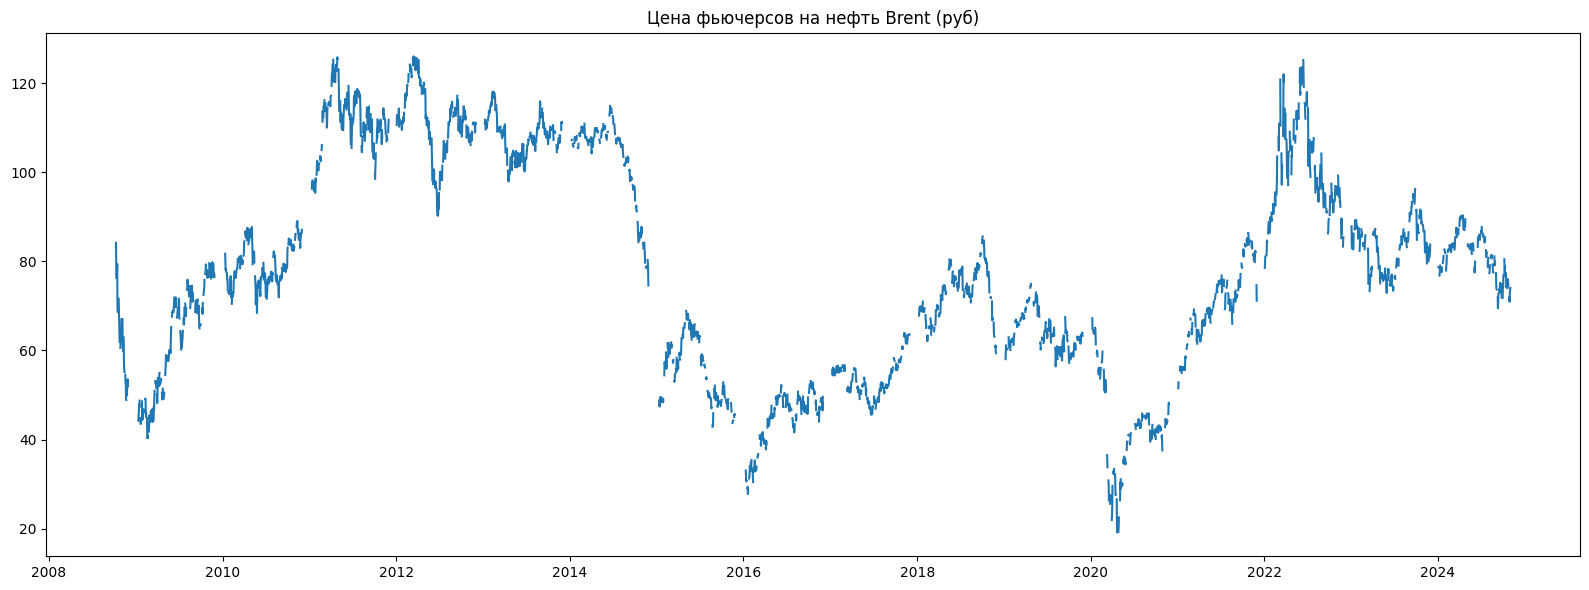

In [22]:
plt.figure(figsize=(16,6))
plt.plot(df_merged['Brent futures']['CLOSE'])
plt.title('Цена фьючерсов на нефть Brent (руб)')
plt.tight_layout()

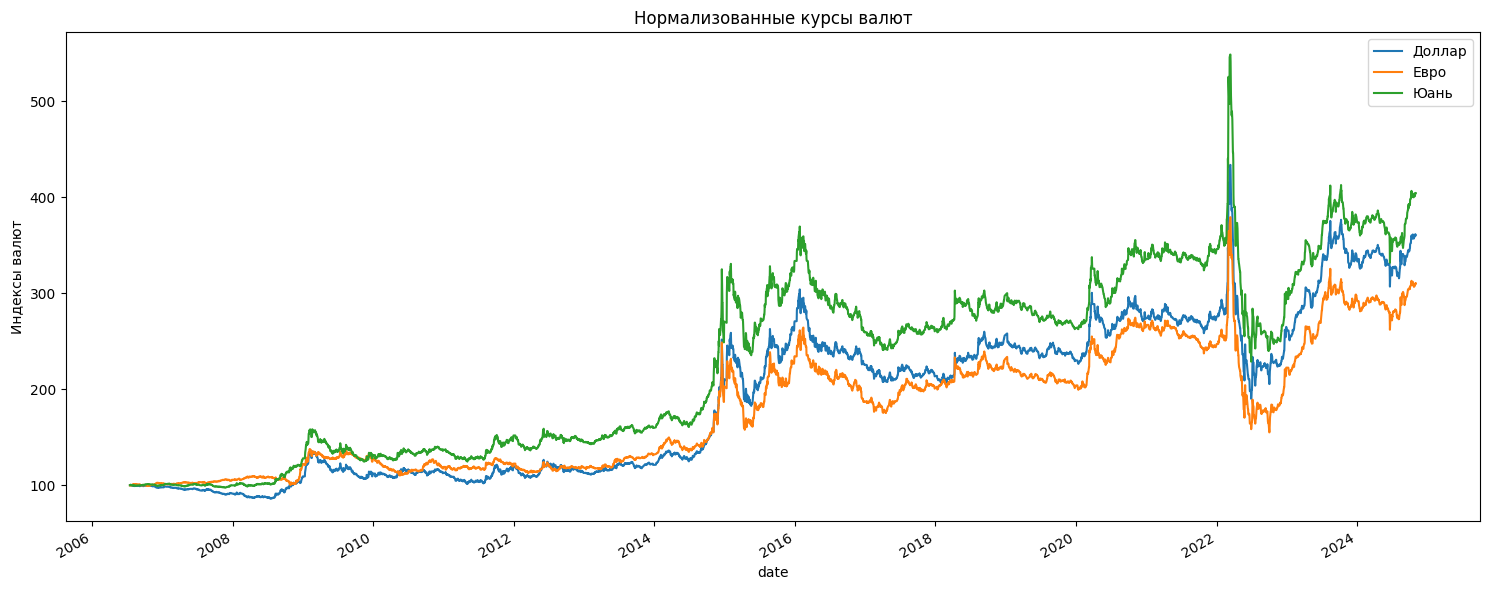

In [23]:
normalized =    df_merged.loc[:,'CB'].drop('rate', axis=1) /\
                df_merged.loc[:,'CB'].drop('rate', axis=1).iloc[0, :] * 100
normalized.plot(figsize=(15, 6))
plt.title('Нормализованные курсы валют')
plt.ylabel('Индексы валют')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
df_merged.loc[:,'CB'].drop('rate', axis=1).describe()

,Доллар,Евро,Юань
count,5400.000000,5400.000000,5400.000000
mean,48.272931,57.819522,7.168433
std,21.807041,21.179217,3.182899
min,23.125500,33.724700,3.279440
25%,29.791575,39.973200,4.473982
50%,34.722250,46.332800,5.485415
75%,65.637000,73.945175,9.782647
max,116.751700,128.952300,18.467800


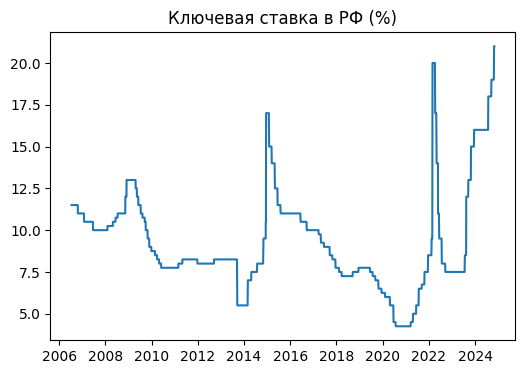

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(df_merged.loc[:,'CB']['rate'])
plt.title('Ключевая ставка в РФ (%)')
plt.show()

In [26]:
df_merged.loc[:, 'CB']['rate'].describe().to_frame()

,rate
count,5400.000000
mean,9.308843
std,2.847561
min,4.250000
25%,7.750000
50%,8.250000
75%,10.750000
max,21.000000


### Построение корреляционной матрицы валют

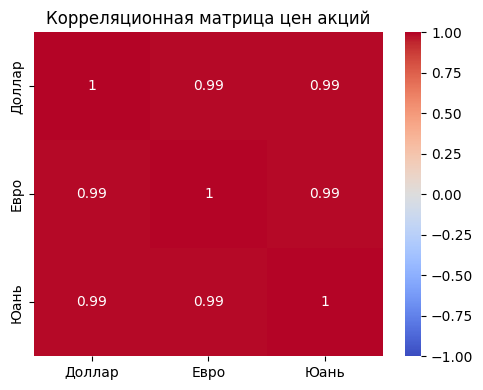

In [27]:
plt.figure(figsize=(5, 4))
correlation_matrix = df_merged.loc[:,'CB'].drop('rate', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляционная матрица цен акций")
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

## 6. Обработка временных рядов

### Перевод временных рядов в стационарные

<Axes: xlabel='date'>

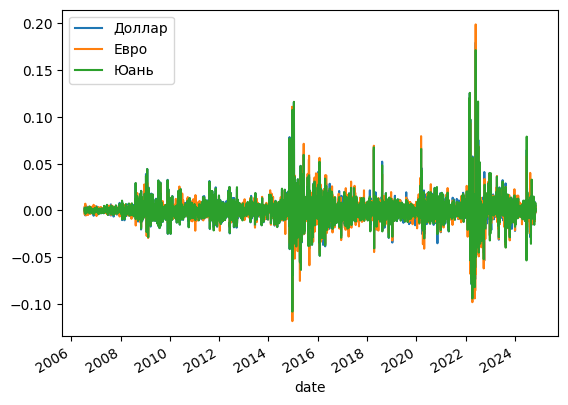

In [28]:
df_XR_stat = df_merged.loc[:,'CB'].drop('rate', axis=1).pct_change()
df_XR_stat.plot()

In [29]:
df_XR_stat.apply(adf_test)

Доллар    0.0
Евро      0.0
Юань      0.0
dtype: float64

<Axes: xlabel='date'>

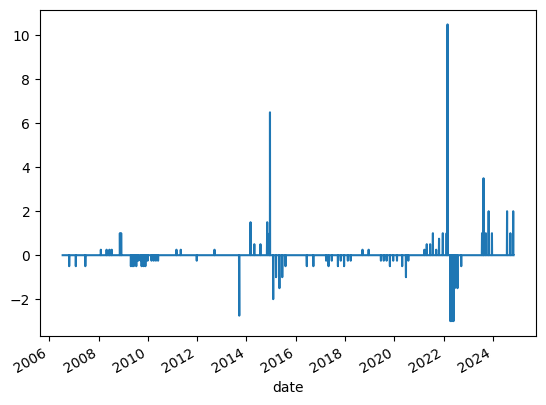

In [30]:
df_KR_stat = df_merged.loc[:,'CB']['rate'].diff()
df_KR_stat.plot()

In [31]:
df_KR_stat.to_frame().apply(adf_test)

rate    0.0
dtype: float64

<Axes: xlabel='date'>

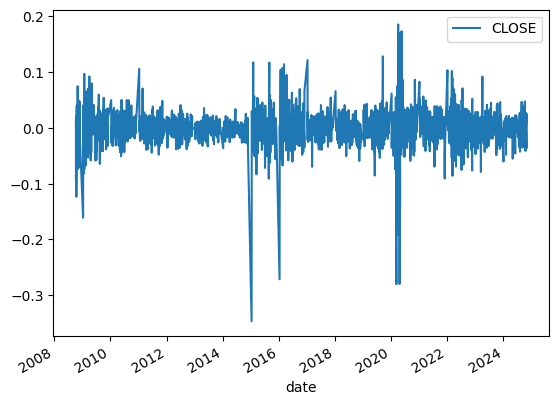

In [32]:
df_brent_stat = df_merged['Brent futures']['CLOSE'].dropna().pct_change().to_frame()
df_brent_stat.plot()

In [33]:
df_brent_stat.describe()

,CLOSE
count,3123.000000
mean,0.000323
std,0.026336
min,-0.346515
25%,-0.010240
50%,0.000946
75%,0.011453
max,0.185600


### Анализ автокорреляции (ACF) и частичной автокорреляции (PACF)

#### Курсы валют

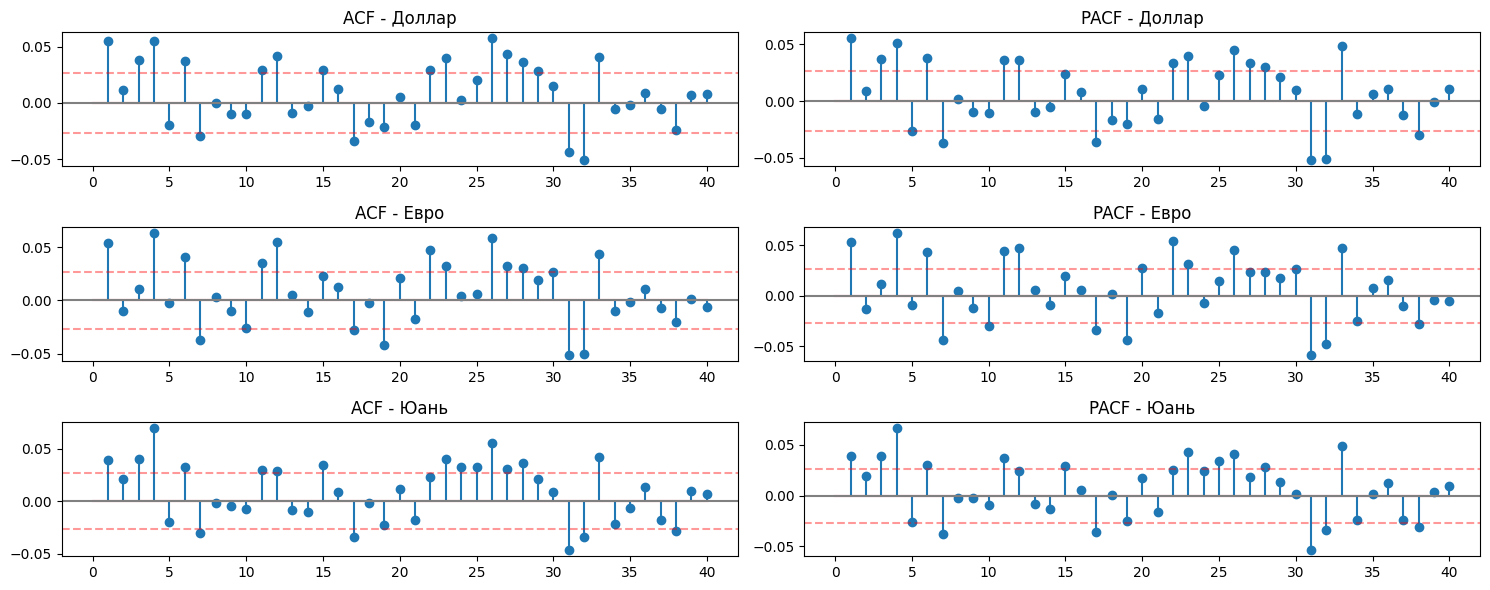

In [34]:
plot_acf_pacf(df_XR_stat)

#### Фьючерсы на Brent

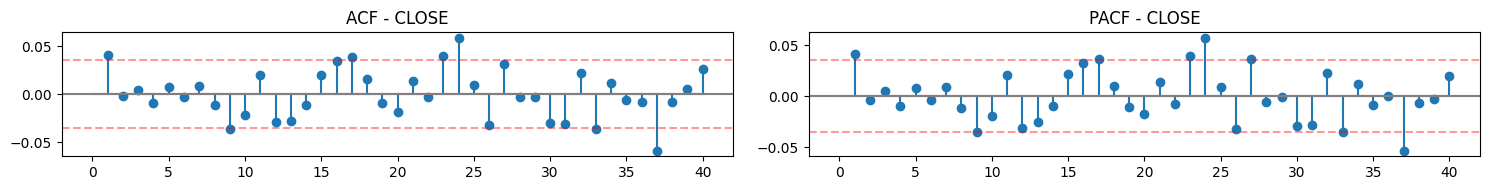

In [35]:
plot_acf_pacf(df_brent_stat)

## 7. Скользящие окна

Используем формулу сложного $\%$, аналогично доходности, потому что
если курс упал на $10\%$ и потом вырос на $10\%$, то его изменение за этот период составит:
$0.9 \cdot 1.1 = 0.99$, т.е. $-1\%$, а не $0$

#### Курсы валют

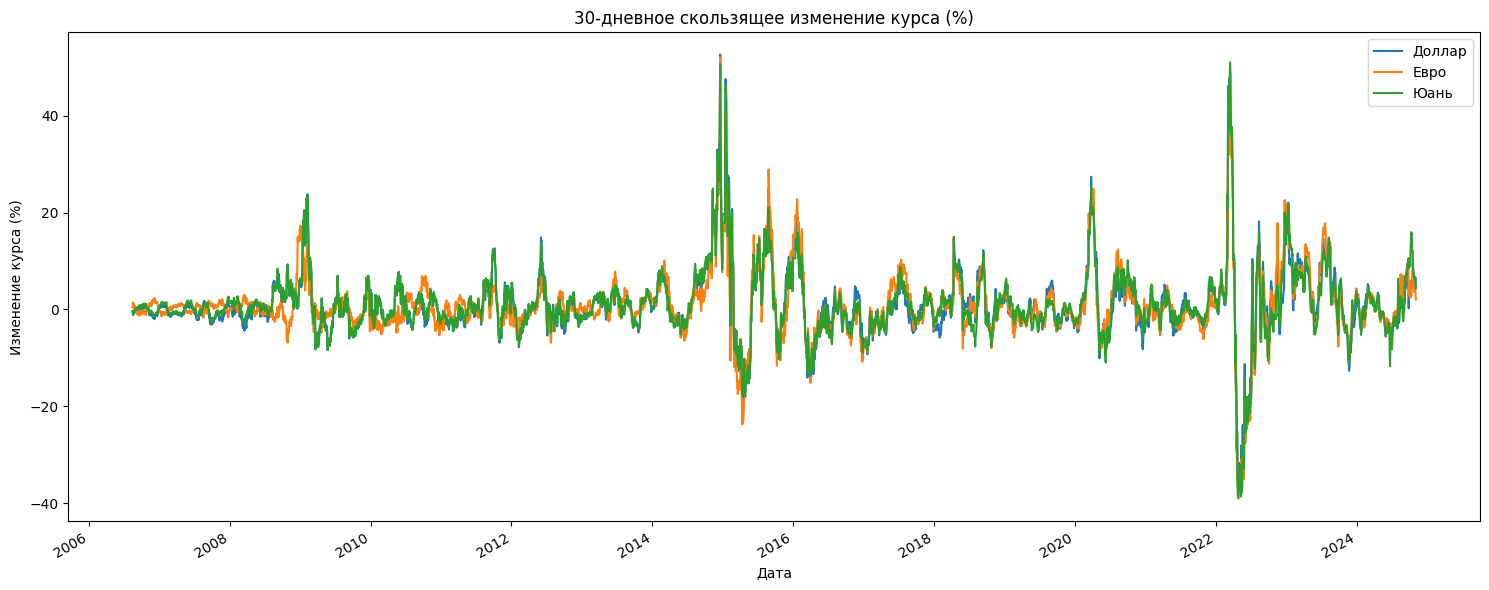

In [36]:
vol_window = 30
rolling_vol = df_XR_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение курса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение курса (%)')
plt.legend()
plt.tight_layout()
plt.show()

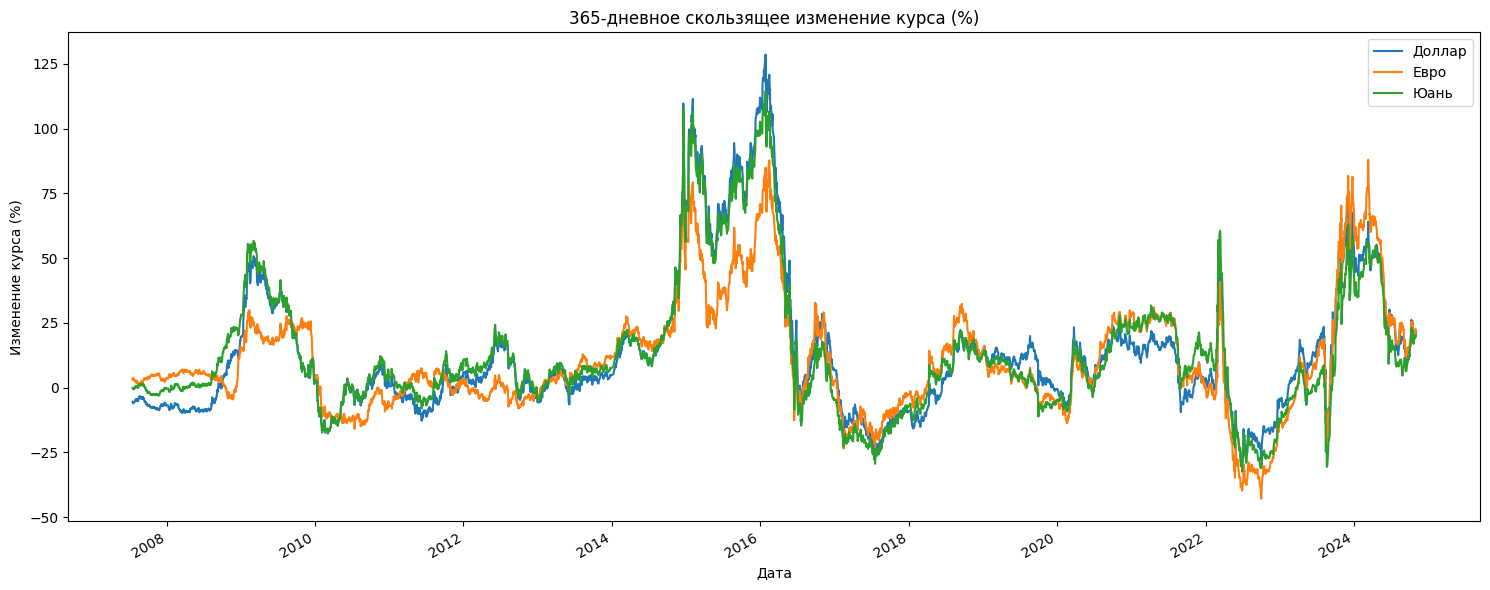

In [37]:
vol_window = 365
rolling_vol = df_XR_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение курса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение курса (%)')
plt.legend()
plt.tight_layout()
plt.show()

#### Фьючерсы на Brent

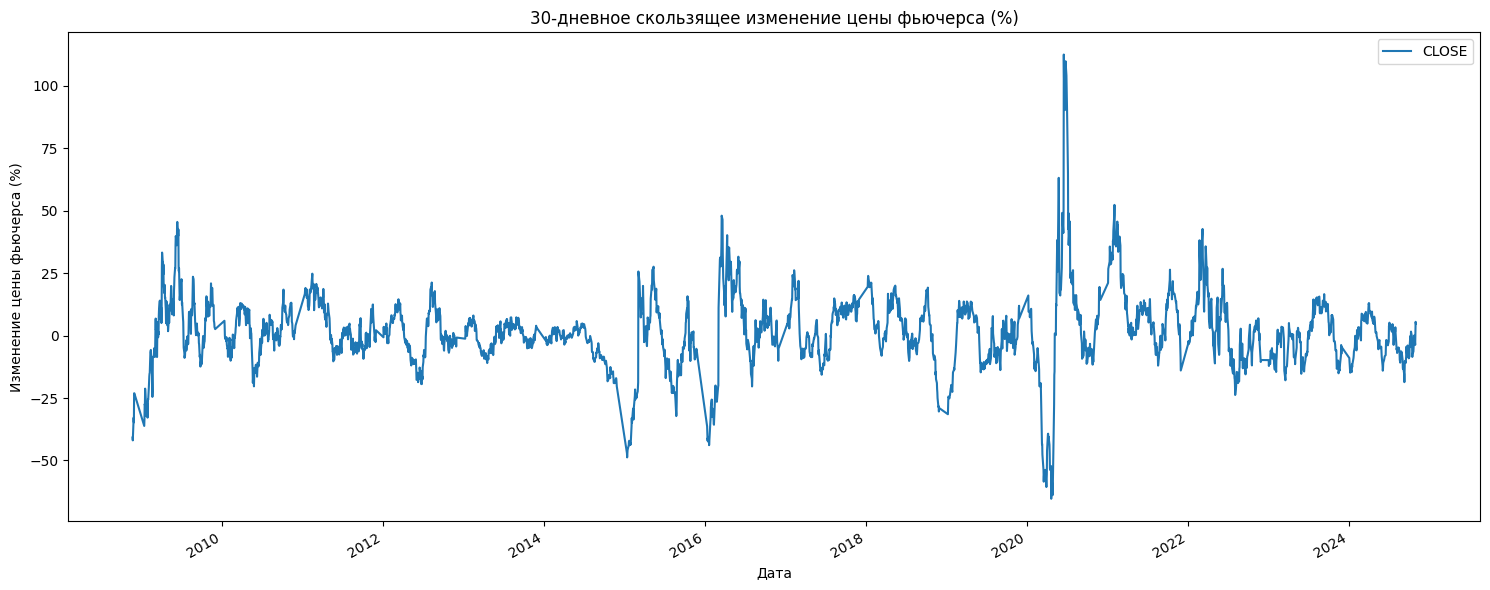

In [38]:
vol_window = 30
rolling_vol = df_brent_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение цены фьючерса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение цены фьючерса (%)')
plt.legend()
plt.tight_layout()
plt.show()

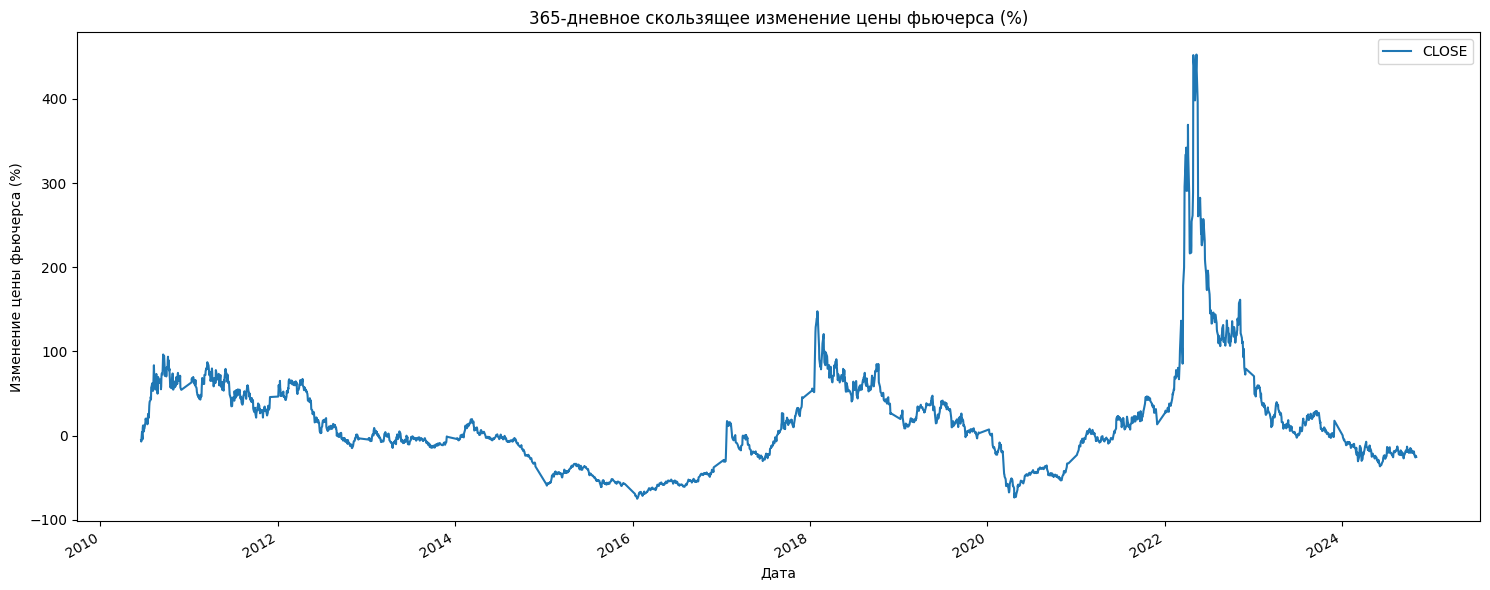

In [39]:
vol_window = 365
rolling_vol = df_brent_stat.rolling(window=vol_window).apply(lambda x: (1 + x).prod() - 1) * 100
rolling_vol.plot(figsize=(15, 6))
plt.title(f'{vol_window}-дневное скользящее изменение цены фьючерса (%)')
plt.xlabel('Дата')
plt.ylabel('Изменение цены фьючерса (%)')
plt.legend()
plt.tight_layout()
plt.show()